### Creating a Time Series Model on BTCUSD on a 4H Time Horizon

* An Autoregression model (AR) with multiple lags was explored, including that of correlated coins.
* Research found no significant alpha increase and thus kept features to its own timeseries.
* Last feature to have been added was BTCUSD log volume, which increased the Sharpe by 0.4.

* We will be using a linear model inside Pytorch for the weight and bias.

In [319]:

import polars as pl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from src import research

research.set_seed(42)



from binance.client import Client
import pandas as pd
from datetime import datetime
import time

client = Client()

symbol = ["BTCUSDT"]
interval = "4h"
start_date = "2020-11-11"
end_date = datetime.now().strftime("%d %b, %Y %H:%M:%S")

def get_data(symbol):
    cols = [
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    df = pd.DataFrame(klines, columns=cols)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df[["timestamp", "open", "high", "low", "close", "volume"]].astype(float, errors="ignore")
    df.set_index("timestamp", inplace=True)
    return df

# Loop through symbols and store in a dict
data = {}
for sym in symbols:
    print(f"Downloading {sym}...")
    data[sym] = get_data(sym)
    time.sleep(0.5)


# Combine both BTC and XRP close + volume into one DataFrame
prices = pd.concat(
    [
        data[sym][["close", "volume"]]
        .rename(columns={
            "close": f"{sym}_close",
            "volume": f"{sym}_volume"
        })
        for sym in symbols
    ],
    axis=1
)

print(prices.head())


                     BTCUSDT_close  BTCUSDT_volume
timestamp                                         
2020-11-11 00:00:00       15401.90    11252.097142
2020-11-11 04:00:00       15400.51     5830.865996
2020-11-11 08:00:00       15574.48    13706.745887
2020-11-11 12:00:00       15667.27    13545.826971
2020-11-11 16:00:00       15807.58    22805.049300


### Inspect data

In [308]:
prices.describe(include="all")
prices.isna().mean()

BTCUSDT_close       0.000000
BTCUSDT_volume      0.000000
close_log_return    0.000091
log_volume          0.000091
dtype: float64

In [213]:
ts = prices
ts

,BTCUSDT_close,BTCUSDT_volume
timestamp,,
2020-11-11 00:00:00,15401.90,11252.097142
2020-11-11 04:00:00,15400.51,5830.865996
2020-11-11 08:00:00,15574.48,13706.745887
2020-11-11 12:00:00,15667.27,13545.826971
2020-11-11 16:00:00,15807.58,22805.049300
...,...,...
2025-11-10 20:00:00,106011.13,2663.142310
2025-11-11 00:00:00,106456.00,4935.027620
2025-11-11 04:00:00,104783.98,3316.234240


### Feature Engineering
* Step 1:
### Create target and lagged features using log returns

In [214]:
# Creating log return within ts dataframe.
forcast_horizon = 1
#ts = ts.sort_index()
ts['close_log_return']= np.log(ts['BTCUSDT_close']/ts['BTCUSDT_close'].shift(forcast_horizon))
ts['log_volume'] = np.log(ts['BTCUSDT_volume']/ts['BTCUSDT_volume'].shift(forcast_horizon))
ts

,BTCUSDT_close,BTCUSDT_volume,close_log_return,log_volume
timestamp,,,,
2020-11-11 00:00:00,15401.90,11252.097142,NaN,NaN
2020-11-11 04:00:00,15400.51,5830.865996,-0.000090,-0.657389
2020-11-11 08:00:00,15574.48,13706.745887,0.011233,0.854723
2020-11-11 12:00:00,15667.27,13545.826971,0.005940,-0.011810
2020-11-11 16:00:00,15807.58,22805.049300,0.008916,0.520903
...,...,...,...,...
2025-11-10 20:00:00,106011.13,2663.142310,0.001824,-0.034422
2025-11-11 00:00:00,106456.00,4935.027620,0.004188,0.616852
2025-11-11 04:00:00,104783.98,3316.234240,-0.015831,-0.397528


In [215]:
# Create lagged features
target = 'close_log_return'
max_lags = 4
forcast_horizon = 1

# create 4 lagged features

ts = ts.copy() # this is to avoid setting with copy warning

ts[f'{target}_lag_1'] = ts[target].shift(forcast_horizon * 1)
ts[f'{target}_lag_2'] = ts[target].shift(forcast_horizon * 2)
ts[f'{target}_lag_3'] = ts[target].shift(forcast_horizon * 3)
ts[f'{target}_lag_4'] = ts[target].shift(forcast_horizon * 4)

ts['log_volume_lag_1'] = ts['log_volume'].shift(forcast_horizon * 1)
ts['log_volume_lag_2'] = ts['log_volume'].shift(forcast_horizon * 2)
ts['log_volume_lag_3'] = ts['log_volume'].shift(forcast_horizon * 3)



In [216]:
# better practice would be ts = ts.dropna()
ts.dropna(inplace=True)
ts

,BTCUSDT_close,BTCUSDT_volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,
2020-11-11 20:00:00,15684.24,11329.161162,-0.007833,-0.699602,0.008916,0.005940,0.011233,-0.000090,0.520903,-0.011810,0.854723
2020-11-12 00:00:00,15628.14,11628.021693,-0.003583,0.026038,-0.007833,0.008916,0.005940,0.011233,-0.699602,0.520903,-0.011810
2020-11-12 04:00:00,15862.75,10308.733321,0.014900,-0.120426,-0.003583,-0.007833,0.008916,0.005940,0.026038,-0.699602,0.520903
2020-11-12 08:00:00,15762.55,27118.660196,-0.006337,0.967231,0.014900,-0.003583,-0.007833,0.008916,-0.120426,0.026038,-0.699602
2020-11-12 12:00:00,16125.01,20899.418386,0.022735,-0.260501,-0.006337,0.014900,-0.003583,-0.007833,0.967231,-0.120426,0.026038
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10 20:00:00,106011.13,2663.142310,0.001824,-0.034422,0.006999,-0.010381,-0.002680,0.004080,-0.730176,0.886952,-0.130207
2025-11-11 00:00:00,106456.00,4935.027620,0.004188,0.616852,0.001824,0.006999,-0.010381,-0.002680,-0.034422,-0.730176,0.886952
2025-11-11 04:00:00,104783.98,3316.234240,-0.015831,-0.397528,0.004188,0.001824,0.006999,-0.010381,0.616852,-0.034422,-0.730176


### Visualize the log returns distribution for outliers.

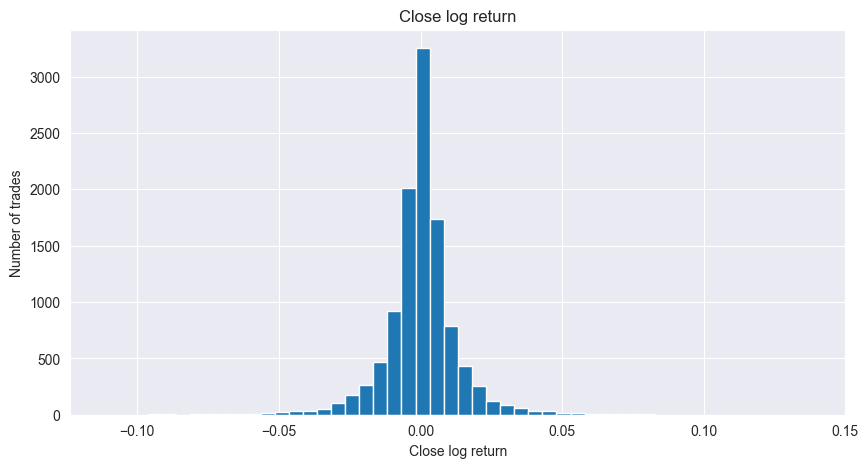

In [218]:
# Plot distribution

ts['close_log_return'].hist(bins=50, figsize=(10,5))
plt.title('Close log return')
plt.xlabel('Close log return')
plt.ylabel('Number of trades')

plt.show()


### Constructing the Model

In [219]:
# we will use a linear model from torch.
# reason for linear model is the simplicity and interpretation
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Splitting by time
* Creating an (AR) model.
* We are aiming to predict one return by its own lags.
* splitting your data by scratch ensures no data leakage

In [270]:
 features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3','log_volume_lag_1','log_volume_lag_2']
 target = 'close_log_return'
 test_size = 0.25 #

In [271]:
len(ts)`

10955

In [272]:
int(len(ts)* test_size)

2738

In [273]:
# to split the data by time, we will split it by the index.
# this will give us the train size below
split_idx = int(len(ts) *(1-test_size))
split_idx

8216

In [274]:
# split time series into 2 parts

ts_train,ts_test = ts[:split_idx], ts[split_idx:]

ts_train.head()

,BTCUSDT_close,BTCUSDT_volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,
2020-11-11 20:00:00,15684.24,11329.161162,-0.007833,-0.699602,0.008916,0.005940,0.011233,-0.000090,0.520903,-0.011810,0.854723
2020-11-12 00:00:00,15628.14,11628.021693,-0.003583,0.026038,-0.007833,0.008916,0.005940,0.011233,-0.699602,0.520903,-0.011810
2020-11-12 04:00:00,15862.75,10308.733321,0.014900,-0.120426,-0.003583,-0.007833,0.008916,0.005940,0.026038,-0.699602,0.520903
2020-11-12 08:00:00,15762.55,27118.660196,-0.006337,0.967231,0.014900,-0.003583,-0.007833,0.008916,-0.120426,0.026038,-0.699602
2020-11-12 12:00:00,16125.01,20899.418386,0.022735,-0.260501,-0.006337,0.014900,-0.003583,-0.007833,0.967231,-0.120426,0.026038


In [275]:
ts_test.tail()

,BTCUSDT_close,BTCUSDT_volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,
2025-11-10 20:00:00,106011.13,2663.14231,0.001824,-0.034422,0.006999,-0.010381,-0.002680,0.004080,-0.730176,0.886952,-0.130207
2025-11-11 00:00:00,106456.00,4935.02762,0.004188,0.616852,0.001824,0.006999,-0.010381,-0.002680,-0.034422,-0.730176,0.886952
2025-11-11 04:00:00,104783.98,3316.23424,-0.015831,-0.397528,0.004188,0.001824,0.006999,-0.010381,0.616852,-0.034422,-0.730176
2025-11-11 08:00:00,105311.90,1804.62899,0.005026,-0.608475,-0.015831,0.004188,0.001824,0.006999,-0.397528,0.616852,-0.034422
2025-11-11 12:00:00,105064.38,142.28471,-0.002353,-2.540280,0.005026,-0.015831,0.004188,0.001824,-0.608475,-0.397528,0.616852


In [276]:
# converting into torch tensors
# splitting our input and output into separate variables
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
Y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
Y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)



In [277]:
X_train.shape # row vector


torch.Size([8216, 5])

In [278]:
Y_train.shape # one dimensional tensor

torch.Size([8216])

In [279]:
# We need to put it into a 2 dimensional

Y_train = Y_train.reshape(-1, 1)
Y_train.shape

torch.Size([8216, 1])

In [280]:
Y_test = Y_test.reshape(-1, 1)
Y_test.shape

torch.Size([2739, 1])

In [281]:
# Fit scaler on TRAIN only
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(ts_train[features].values)
X_train_np = x_scaler.transform(ts_train[features].values)
X_test_np  = x_scaler.transform(ts_test[features].values)

# Replace old torch tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)

### Training the model
* I experimented with different loss functions and found the L1Loss to have the best performance.

In [282]:
# specify hyperparameters which can be tweaked to improve model performance

no_epochs = 1000 * 5
lr = 0.0005

# Create Model
model = LinearModel(len(features))

#Loss Function L1Loss/MSE / L1Loss has been the strongest performer through testing
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

print('\nTraining...')
for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, Y_train)

    # Backward pass
    optimizer.zero_grad() # 1. clear old gradients
    loss.backward()       # 2. compute new gradients
    optimizer.step()      # 3. update weights

    # check for improvements by logging
    train_loss = loss.item()

    # logging
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}')

    print('\nLearned parameters:')

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}:\n {param.data.numpy()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        test_loss = criterion(y_hat, Y_test)
        print(f'\nTest loss: {test_loss.item():.6f}, Train loss: {train_loss:.6f}')





Training...

Learned parameters:
linear.weight:
 [[-0.0974861   0.08974352 -0.21722819  0.26214078  0.393738  ]]
linear.bias:
 [-0.32758847]

Test loss: 0.485061, Train loss: 0.461784

Learned parameters:
linear.weight:
 [[-0.09698612  0.08924364 -0.21672818  0.26164082  0.39323795]]
linear.bias:
 [-0.32708848]

Test loss: 0.484286, Train loss: 0.460972

Learned parameters:
linear.weight:
 [[-0.09648632  0.08874382 -0.2162281   0.2611409   0.3927379 ]]
linear.bias:
 [-0.3265885]

Test loss: 0.483511, Train loss: 0.460161

Learned parameters:
linear.weight:
 [[-0.0959866   0.08824426 -0.21572803  0.26064107  0.39223778]]
linear.bias:
 [-0.32608855]

Test loss: 0.482736, Train loss: 0.459351

Learned parameters:
linear.weight:
 [[-0.09548722  0.08774495 -0.21522796  0.26014122  0.3917376 ]]
linear.bias:
 [-0.32558858]

Test loss: 0.481961, Train loss: 0.458542

Learned parameters:
linear.weight:
 [[-0.09498809  0.08724585 -0.21472795  0.25964144  0.39123738]]
linear.bias:
 [-0.32508862]

### Model Trained: Looking at the weight, which is negative, the model picked up a mean reversion signal.
### Model Performance
* Create trade results from testing data.

In [307]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': Y_test.squeeze(),
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
    ).with_columns(
        pl.col('trade_log_return').cum_sum().alias('equity_curve')
    )
#trade_results

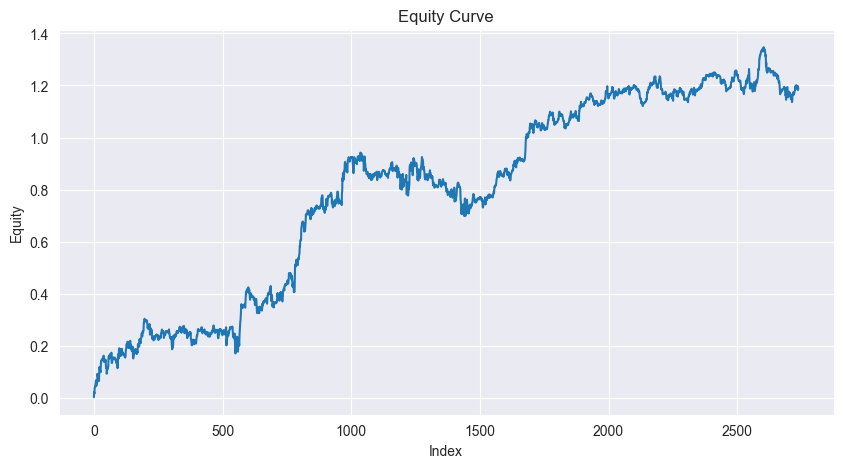

In [312]:
 # plot equity curve in log space
# Convert the Series to a NumPy array for plotting
y = trade_results['equity_curve'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()



### Trade Performance Checking

In [285]:
# performance checking
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000607,0.002818,true,1.0,0.002818,0.002818,0.0
0.00004,0.019863,true,1.0,0.019863,0.022681,0.0
-0.001099,0.005925,false,-1.0,-0.005925,0.016756,-0.005925
-0.000076,-0.019512,true,-1.0,0.019512,0.036268,0.0
0.001564,0.005113,true,1.0,0.005113,0.041381,0.0
…,…,…,…,…,…,…
-0.000241,0.001824,false,-1.0,-0.001824,1.19403,-0.152937
7.7240e-7,0.004188,true,1.0,0.004188,1.198218,-0.148749
0.000075,-0.015831,false,1.0,-0.015831,1.182387,-0.16458


In [304]:
# Max DD log

max_drawdown_log = trade_results['drawdown_log'].min()
print('Max Drawdown Log:',max_drawdown_log)

Max Drawdown Log: -0.24319875240325928


In [287]:
# Putting into simple returns
drawdown_pct = np.exp(max_drawdown_log)-1
drawdown_pct

np.float64(-0.21588434658728994)

In [288]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-215.88434658728994)

In [303]:
# Win rate
win_rate = trade_results['is_won'].mean()
print('Win Rate:',win_rate)

Win Rate: 0.5319459656809055


In [302]:
# Expected Value
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev= win_rate * avg_win + (1-win_rate) * avg_loss
print('Expected Value:',ev)

Expected Value: 0.00043437896072108344


In [291]:
# total log return
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

1.1897640228271484

In [292]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(3.2863056227665983)

In [301]:
1000*compound_return
print("Compound Return:", compound_return)

Compound Return: 3.2863056227665983


In [294]:
# Equity trough

equity_trough = trade_results['equity_curve'].min()
equity_trough

0.002817960688844323

In [295]:
# Equity peak

equity_peak = trade_results['equity_curve'].max()
equity_peak

1.3469672203063965

In [306]:
# std
std = trade_results['trade_log_return'].std()
print('Std Deviation:',std)

Std Deviation: 0.009723283350467682


In [305]:
# Sharpe
mean_ret = trade_results['trade_log_return'].mean()

# 4-hour bars = 6 periods per day * 365 days
annual_factor = np.sqrt(365 * 6)

sharpe = (mean_ret / std) * annual_factor
print("Sharpe Ratio:", sharpe)



Sharpe Ratio: 2.090633462620298


### Adding Transaction Fees

In [314]:
# 2 types of fees:
# 1: maker fee and taker fee

maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1-2*maker_fee)

trade_results = trade_results.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
trade_results = trade_results.with_columns((pl.col('trade_log_return')+pl.col('tx_fee_log')).alias('trade_log_return_net'))
trade_results = trade_results.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
trade_results

roundtrip_fee_log
trade_results


y_hat,y,is_won,signal,trade_log_return,equity_curve,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f64,f64,f64
0.000607,0.002818,true,1.0,0.002818,0.002818,-0.0002,0.002618,0.002618
0.00004,0.019863,true,1.0,0.019863,0.022681,-0.0002,0.019663,0.022281
-0.001099,0.005925,false,-1.0,-0.005925,0.016756,-0.0002,-0.006125,0.016156
-0.000076,-0.019512,true,-1.0,0.019512,0.036268,-0.0002,0.019312,0.035468
0.001564,0.005113,true,1.0,0.005113,0.041381,-0.0002,0.004913,0.040381
…,…,…,…,…,…,…,…,…
-0.000241,0.001824,false,-1.0,-0.001824,1.19403,-0.0002,-0.002024,0.646974
7.7240e-7,0.004188,true,1.0,0.004188,1.198218,-0.0002,0.003988,0.650961
0.000075,-0.015831,false,1.0,-0.015831,1.182387,-0.0002,-0.016031,0.634931


In [249]:
for x in trade_results['signal']:
    print(x)

1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0


### Tweaks:
* I have adjusted the lag to 1 and put the time_interval to 4h. This has increased the sharpe and net equity.

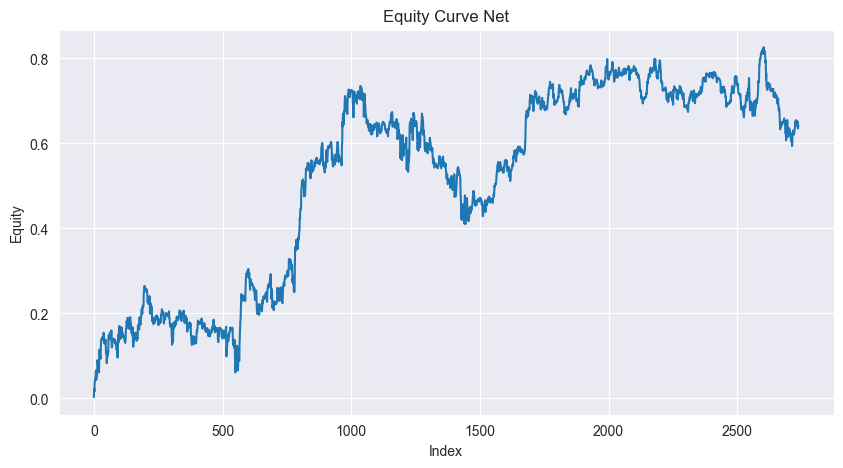

In [315]:
y = trade_results['equity_curve_net'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve Net")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()

In [324]:
torch.save(model.state_dict(), 'model_weights.pth')

### Strategy Development